In [24]:
import numpy as np
import matplotlib.pyplot as plt
import colossus
from colossus.cosmology import cosmology
from colossus.halo import concentration, mass_so, profile_nfw
from plotter import plot, loglogplot
%matplotlib inline

In [ ]:
# will need to test sensitivity to:
# 1. c(M,z) relationship: Zhao+09, Duffy+08, Diemer+19

In [42]:
# global variables
# free parameters of Shi+14 model; can be changed later
beta_def = 1.0
eta_def  = 0.7

G = colossus.utils.constants.G
cm_per_km = 1e5
km_per_kpc = colossus.utils.constants.KPC / cm_per_km # KPC was in cm
s_per_Gyr = colossus.utils.constants.GYR

# can reset cosmology on-the-fly, will start with WMAP 5
cosmology.setCosmology('WMAP5')
print(cosmology.getCurrent())

Cosmology "WMAP5" 
    flat = True, Om0 = 0.2732, Ode0 = 0.7267, Ob0 = 0.0456, H0 = 70.50, sigma8 = 0.8120, ns = 0.9600
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


Text(0, 0.5, '$c$')

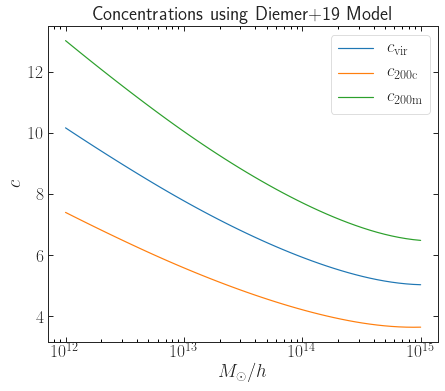

In [28]:
# mass-concentration relationships
# Original Shi paper used duffy08 and vdB+14 used the c(M,z) of Zhao+09
# need to make sure that we use consistent definitions of virial radius, thus concentration, everywhere
# takes the z=0 mass in units of Msun/h
nm = 50
masses = np.logspace(12,15,nm)
cvirs = concentration.concentration(masses, 'vir', 0.0, model = 'diemer19')
c200cs = concentration.concentration(masses, '200c', 0.0, model = 'diemer19')
c200ms = concentration.concentration(masses, '200m', 0.0, model = 'diemer19')
plot(semilogx=True)
plt.plot(masses, cvirs, label=r'$c_\mathrm{vir}$')
plt.plot(masses, c200cs, label=r'$c_\mathrm{200c}$')
plt.plot(masses, c200ms, label=r'$c_\mathrm{200m}$')
plt.title(r'Concentrations using Diemer+19 Model')
plt.legend()
plt.xlabel(r'$M_\odot / h$')
plt.ylabel(r'$c$')

# TODO: vdB+14 uses Zhao et al. 2009, not available in Colossus, so may need to code that up
# this uses the lookback time instead of redshift, so need to get z from t
# NOTE: vdB+14 paper and code use slightly different formulas
# We probably want to use one of the all-cosmology c(M,z) since we will use different definitions of the virial radius

In [38]:
# computing t_d from t_dyn
# the masses are in Msun/h
# the lengths for haloes are in kpc/h
def NFWf(x):
    return np.log(1. + x) - x/(1. + x)

# accepts radius in physical kpc/h
# might change this...
def NFWM(r, M, z, conc_model='diemer19', mass_def='vir'):
    # compute the concentration
    c = concentration.concentration(M, mass_def, z, model=conc_model)
    R = mass_so.M_to_R(M, z, mass_def)
    return M * NFWf(c*r/R) / NFWf(c)

# need to fix unit conversions here...
def t_d(r, M, z, conc_model='diemer19', mass_def='vir', beta=beta_def):
    Menc = NFWM(r, M, z, conc_model, mass_def)
    t_dyn = 2. * np.pi * (r**3 / (G*Menc))**(1./2.) * km_per_kpc / (cosmology.getCurrent().H0 / 100.)
    return beta * t_dyn

6.242115649063551


Text(0, 0.5, '$t_\\mathrm{d}$ [Gyr]')

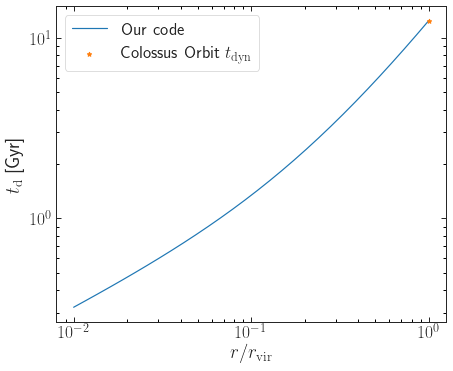

In [60]:
# look at t_d vs. r for a 10^14 Msun/h halo to verify the results

mass = 1e14 #Msun/h
Rvir = mass_so.M_to_R(mass, 0.0, 'vir')
nr = 30
rads = np.logspace(np.log10(0.01*Rvir),np.log10(Rvir), nr)

dt = mass_so.dynamicalTime(0.0, 'vir', definition='orbit')
print(dt / 2)

loglogplot()
plt.plot(rads/Rvir, t_d(rads, mass, 0.0, mass_def='vir')/s_per_Gyr, label=r'Our code')
plt.plot([1.], [dt], '*', label=r'Colossus Orbit $t_\mathrm{dyn}$')
plt.legend()
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$t_\mathrm{d}$ [Gyr]')
# it agrees, so our calculation seems to be correct
# it disagrees by ~factor of 2~ with Shi and Komatsu, which is explained in their erratum
# hence, our result is indeed correct
# need to check later results to see if they actually use beta*t_dyn / 2 or beta*t_dyn for further stuff

In [160]:
# Komatsu and Seljak Model
# Here, c_nfw is defined using the virialization condition of Lacey & Cole (1993) and Nakamura & Suto (1997)
# should make sure that it is pretty similar to Bryan and Norman

# once we verify all results, we can speed this up by removing redundant calculations

def Gamma(c_nfw):
    return 1.15 + 0.01*(c_nfw - 6.5)

def eta0(c_nfw):
    return 0.00676*(c_nfw - 6.5)**2 + 0.206*(c_nfw - 6.5) + 2.48

def NFWPhi(r, M, z, conc_model='diemer19', mass_def='vir'):
    c = concentration.concentration(M, mass_def, z, model=conc_model)
    R = mass_so.M_to_R(M, z, mass_def)
    if(type(r) != np.ndarray and r == 0):
        return -1. * (G * M / R) * (c / NFWf(c))
    else:
        return -1. * (G * M / R) * (c / NFWf(c)) * (np.log(1. + c*r/R) / (c*r/R))

# this now agrees with Komatsu and Seljak eqn 19 for theta
# the confusion was that rho0 / P0 is 3*eta0^-1 and then units removed by scaling by R/GM
def theta(r, M, z, conc_model='diemer19', mass_def='vir'):
    c = concentration.concentration(M, mass_def, z, model=conc_model)
    R = mass_so.M_to_R(M, z, mass_def)
    # the rho0/P0 is actually 3eta^-1(0) * R/(GM) from Komatsu and Seljak
    rho0_by_P0 = 3*eta0(c)**-1 * R/(G*M)
    return 1. + ((Gamma(c) - 1.) / Gamma(c))*rho0_by_P0*(NFWPhi(0, M, z, conc_model='diemer19', mass_def='vir')-NFWPhi(r, M, z, conc_model='diemer19', mass_def='vir'))

# arbitrary units for now while we figure out what to do with the normalization
def rho_gas(r, M, z, conc_model='diemer19', mass_def='vir'):
    c = concentration.concentration(M, mass_def, z, model=conc_model)
    return theta(r, M, z, conc_model, mass_def)**(1.0 / (Gamma(c) - 1.0))

# in km/s
def sig2_tot(r, M, z, conc_model='diemer19', mass_def='vir'):
    c = concentration.concentration(M, mass_def, z, model=conc_model)
    R = mass_so.M_to_R(M, z, mass_def)
    rho0_by_P0 = 3*eta0(c)**-1 * R/(G*M)
    return (1.0 / rho0_by_P0) * theta(r, M, z, conc_model, mass_def)
# the actual Ptot / rho_gas code will only compute the concentration once, no need to do it all the way down

Text(0, 0.5, '$\\theta$')

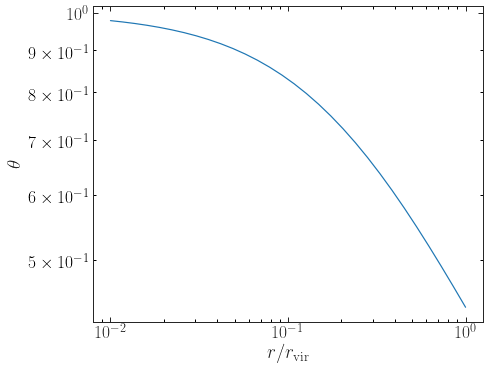

In [146]:
# let's see how theta behaves
mass = 10**14.5 #Msun/h
Rvir = mass_so.M_to_R(mass, 0.0, 'vir')
nr = 30
rads = np.logspace(np.log10(0.01*Rvir),np.log10(Rvir), nr)

loglogplot()
plt.plot(rads/Rvir, theta(rads, mass, 0.0, mass_def='vir'))
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$\theta$')

Text(0, 0.5, '$\\frac{\\Gamma}{\\Gamma - 1}$')

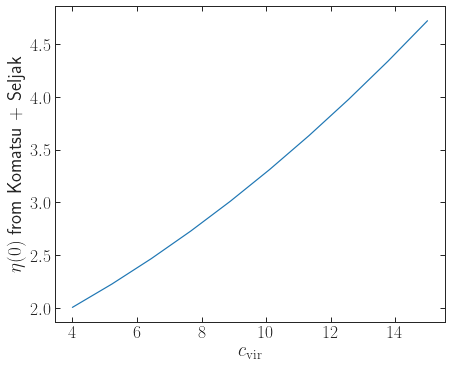

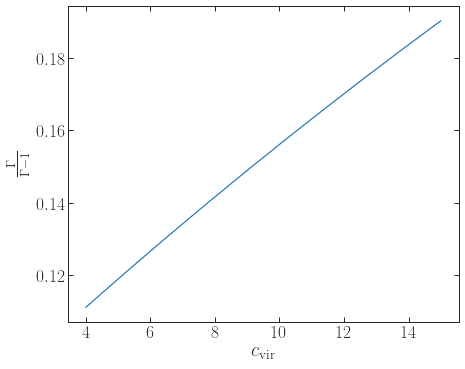

In [147]:
concs = np.linspace(4,15,10)
plot()
plt.plot(concs, eta0(concs))
plt.xlabel(r'$c_\mathrm{vir}$'); plt.ylabel(r'$\eta(0)$ from Komatsu + Seljak')
plot()
plt.plot(concs, ((Gamma(concs) - 1.) / Gamma(concs)))
plt.xlabel(r'$c_\mathrm{vir}$'); plt.ylabel(r'$\frac{\Gamma}{\Gamma - 1}$')

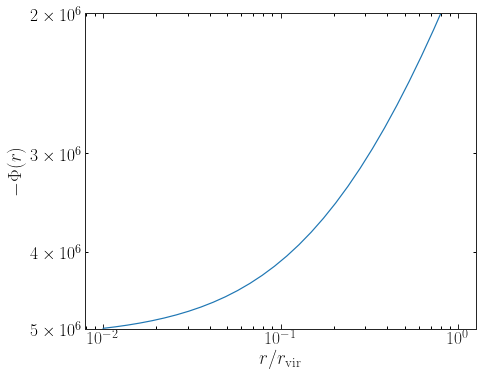

In [150]:
mass = 10**14.5 #Msun/h
Rvir = mass_so.M_to_R(mass, 0.0, 'vir')
nr = 30
rads = np.logspace(np.log10(0.01*Rvir),np.log10(Rvir), nr)

loglogplot()
plt.plot(rads/Rvir, -1.*NFWPhi(rads, mass, 0.0, mass_def='vir'))
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$-\Phi(r)$')
plt.ylim(5e6, 2e6)
plt.gca().invert_yaxis()

0.6688653804972079


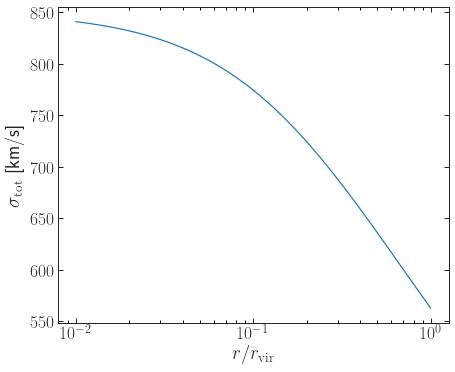

In [162]:
mass = 10**14.5 #Msun/h
Rvir = mass_so.M_to_R(mass, 0.0, 'vir')
nr = 30
rads = np.logspace(np.log10(0.01*Rvir),np.log10(Rvir), nr)

plot(semilogx=True)
plt.plot(rads/Rvir, (sig2_tot(rads, mass, 0.0, mass_def='vir'))**(1./2.))
plt.xlabel(r'$r / r_\mathrm{vir}$')
plt.ylabel(r'$\sigma_\mathrm{tot}$ [km/s]')

print(sig2_tot(rads[-1], mass, 0.0, mass_def='vir')**(1./2.) / sig2_tot(rads[0], mass, 0.0, mass_def='vir')**(1./2.))

# what happens to Komatsu-Seljak model when you have c < 6.5?

# we now have recovered the result of Fig 4 from Komatsu and Seljak

Text(0.5, 0, '$r / r_\\mathrm{vir}$')

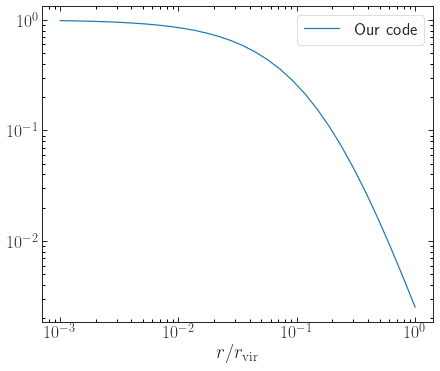

In [153]:
mass = 10**14.5 #Msun/h
Rvir = mass_so.M_to_R(mass, 0.0, 'vir')
nr = 30
rads = np.logspace(np.log10(0.001*Rvir),np.log10(Rvir), nr)

loglogplot()
plt.plot(rads/Rvir, rho_gas(rads, mass, 0.0, mass_def='vir'), label=r'Our code')
plt.legend()
plt.xlabel(r'$r / r_\mathrm{vir}$')

# now this is starting to look pretty good

In [ ]:
# want to reproduce Shi/Komatsu Figs 2,3,4 (and then something similar to 1 from vdB+14)

In [ ]:
# general pipeline will look like the following:
# for cosm in cosmologies:
#      for mass in halo_masses:
#                # set initial conditions
#           for t in times:
#                get the t_d values for each radius and evolve all radii forward one timestep